In [2]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
 
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

dataRepo = os.getcwd() + "/Figure2_Data/"

# Figure 2A

In [7]:
#read in nuclear intensity files
dose5mnuc_msn2_0418 = pd.read_csv(dataRepo + '20180601_p2CTSeed_1m5mall_nuc.csv', header=None)
dose5mnuc_pho4 = pd.read_csv(dataRepo + '20180315_p1CTSeed_5m_nuc.csv', header=None)
dose5mnuc_133_1, dose5mnuc_133_2, dose5mnuc_133_3 = [pd.read_csv(x, header=None) for x in
                                                     glob.glob(dataRepo + '20180614_p*CTSeed_1m5m_yLO133_nuc.csv')]

In [8]:
#read in cytoplasm intensity files
dose5mcyt_msn2_0418 = pd.read_csv(dataRepo + '20180601_p2CTSeed_1m5mall_cyt.csv', header=None)
dose5mcyt_pho4 = pd.read_csv(dataRepo + '20180315_p1CTSeed_5m_cyt.csv', header=None)
dose5mcyt_133_1, dose5mcyt_133_2, dose5mcyt_133_3 = [pd.read_csv(x, header=None) for x in
                                                     glob.glob(dataRepo + '20180614_p*CTSeed_1m5m_yLO133_cyt.csv')]

In [9]:
#read in background intensity files
dose5mbkg_msn2_0418 = pd.read_csv(dataRepo + '20180601_p2CTSeed_1m5mall_bkg.csv', header=None)
dose5mbkg_pho4 = pd.read_csv(dataRepo + '20180315_p1CTSeed_5m_bkg.csv', header=None)
dose5mbkg_133_1, dose5mbkg_133_2, dose5mbkg_133_3 = [pd.read_csv(x, header=None) for x in
                                                     glob.glob(dataRepo + '20180614_p*CTSeed_1m5m_yLO133_bkg.csv')]

In [10]:
#adjust DF of brightness by background
def bkgAdj(brightDF, bkgVec):
    brightAdj = brightDF.apply(lambda x: x-bkgVec.iloc[0,:], 0)
    return brightAdj
#calculate nuclear/cytoplasmic enrichment and normalize
def nucEnrich(nucDF, cytoDF):
    nucCytoEnrich = nucDF/cytoDF
    normNCEnrich = nucCytoEnrich.apply(lambda x: x/nucCytoEnrich.iloc[0,:], 1)
    return [nucCytoEnrich, normNCEnrich]

In [11]:
#adjust nuclear intensity and cytoplasmic intensity by subtracting the background
d5_nuc_list = [dose5mnuc_msn2_0418, dose5mnuc_pho4, dose5mnuc_133_1, dose5mnuc_133_2, dose5mnuc_133_3]
d5_cyt_list = [dose5mcyt_msn2_0418, dose5mcyt_pho4, dose5mcyt_133_1, dose5mcyt_133_2, dose5mcyt_133_3]
d5_bkg_list = [dose5mbkg_msn2_0418, dose5mbkg_pho4, dose5mbkg_133_1, dose5mbkg_133_2, dose5mbkg_133_3]


d5mnucAdj_msn2_0418, d5mnucAdj_pho4, d5mnucAdj_133_1, d5mnucAdj_133_2, d5mnucAdj_133_3 = [bkgAdj(d5_nuc_list[i], d5_bkg_list[i]) 
                                                                                          for i in range(len(d5_bkg_list))]

d5mcytAdj_msn2_0418, d5mcytAdj_pho4, d5mcytAdj_133_1, d5mcytAdj_133_2, d5mcytAdj_133_3 = [bkgAdj(d5_cyt_list[i], d5_bkg_list[i]) 
                                                                                          for i in range(len(d5_bkg_list))]

In [12]:
def rmUntrackedCells(nucDF, cytDF, maxUntrackedFrames):
    #untracked cells often have 0 or negative reading (can be used for bkg-adj cells or not adjusted)
    pass0Cutoff_nucDF = nucDF.apply(lambda x: sum(x<=0) > maxUntrackedFrames, 0)
    pass0Cutoff_cytDF = cytDF.apply(lambda x: sum(x<=0) > maxUntrackedFrames, 0)
    nucDF_woOutliers = nucDF.drop(list(np.where(pass0Cutoff_nucDF)[0]), axis=1)
    cytDF_woOutliers =cytDF.drop(list(np.where(pass0Cutoff_nucDF)[0]), axis=1)
    return [nucDF_woOutliers, cytDF_woOutliers]

def rmOutliers(normNCDF, maxNegFrames): 
    #add in removal of cells which have negative values at any point
    passNegCutoffDF = normNCDF.apply(lambda x: sum(x<0) > maxNegFrames, 0)
    normNCDFwoOutliers = normNCDF.drop(list(np.where(passNegCutoffDF)[0]), axis=1)
    return normNCDFwoOutliers

In [13]:
#drop cells which are untracked for more than 3 frames
d5mnucAdj_msn2_rm_UT_0418, d5mcytAdj_msn2_rm_UT_0418 = rmUntrackedCells(d5mnucAdj_msn2_0418, d5mcytAdj_msn2_0418, 3)
d5mnucAdj_pho4_rm_UT, d5mcytAdj_pho4_rm_UT = rmUntrackedCells(d5mnucAdj_pho4, d5mcytAdj_pho4, 3)
d5mnucAdj_133_rm_UT_0613_1, d5mcytAdj_133_rm_UT_0613_1 = rmUntrackedCells(d5mnucAdj_133_1, d5mcytAdj_133_1, 3)
d5mnucAdj_133_rm_UT_0613_2, d5mcytAdj_133_rm_UT_0613_2 = rmUntrackedCells(d5mnucAdj_133_2, d5mcytAdj_133_2, 3)
d5mnucAdj_133_rm_UT_0613_3, d5mcytAdj_133_rm_UT_0613_3 = rmUntrackedCells(d5mnucAdj_133_3, d5mcytAdj_133_3, 3)

In [14]:
#calculate nuclear enrichment
d5mnucCytoEnr_msn2_rm_UT_0418, d5mnormNucCytoEnr_msn2_rm_UT_0418 = nucEnrich(d5mnucAdj_msn2_rm_UT_0418, d5mcytAdj_msn2_rm_UT_0418)
d5mnucCytoEnr_pho4_rm_UT, d5mnormNucCytoEnr_pho4_rm_UT = nucEnrich(d5mnucAdj_pho4_rm_UT, d5mcytAdj_pho4_rm_UT)
d5mnucCytoEnr_133_rm_UT_1, d5mnormNucCytoEnr_133_rm_UT_1 = nucEnrich(d5mnucAdj_133_rm_UT_0613_1, d5mcytAdj_133_rm_UT_0613_1)
d5mnucCytoEnr_133_rm_UT_2, d5mnormNucCytoEnr_133_rm_UT_2 = nucEnrich(d5mnucAdj_133_rm_UT_0613_2, d5mcytAdj_133_rm_UT_0613_2)
d5mnucCytoEnr_133_rm_UT_3, d5mnormNucCytoEnr_133_rm_UT_3 = nucEnrich(d5mnucAdj_133_rm_UT_0613_3, d5mcytAdj_133_rm_UT_0613_3)

In [16]:
#drop cells which go negative at some point
d5mnormNucCytoEnr_msn2_rm2_0418 = rmOutliers(d5mnormNucCytoEnr_msn2_rm_UT_0418, 0)
d5mnormNucCytoEnr_pho4_rm2 = rmOutliers(d5mnormNucCytoEnr_pho4_rm_UT, 0)
d5mnormNucCytoEnr_133_rm2_1 = rmOutliers(d5mnormNucCytoEnr_133_rm_UT_1, 0)
d5mnormNucCytoEnr_133_rm2_2 = rmOutliers(d5mnormNucCytoEnr_133_rm_UT_2, 0)
d5mnormNucCytoEnr_133_rm2_3 = rmOutliers(d5mnormNucCytoEnr_133_rm_UT_3, 0)

In [17]:
#the images on 04/18 had the light input start 2.5m later than the other days, so we will drop the first 5 timepoints
d5mnormNucCytoEnr_msn2_rm_0418_ns = d5mnormNucCytoEnr_msn2_rm2_0418.iloc[5:, :].copy()
d5mnormNucCytoEnr_133_rm_all = pd.concat([d5mnormNucCytoEnr_133_rm2_1, d5mnormNucCytoEnr_133_rm2_2, 
                                          d5mnormNucCytoEnr_133_rm2_3], axis=1, ignore_index=True)

In [21]:
#turn the wide dataframe into long
longd5mnormNucCyto_msn2_rm2_0418 = pd.melt(d5mnormNucCytoEnr_msn2_rm2_0418)
longd5mnormNucCyto_msn2_rm_0418_ns = pd.melt(d5mnormNucCytoEnr_msn2_rm_0418_ns)
longd5mnormNucCyto_pho4_rm = pd.melt(d5mnormNucCytoEnr_pho4_rm2)
longd5mnormNucCyto_133_rm_0613 = pd.melt(d5mnormNucCytoEnr_133_rm_all)

longd5mnormNucCyto_msn2_rm2_0418["timepoint"] = np.arange(0,d5mnormNucCytoEnr_msn2_rm2_0418.shape[0]/2.0, 
                                                     step=0.5).tolist()*d5mnormNucCytoEnr_msn2_rm2_0418.shape[1]
longd5mnormNucCyto_msn2_rm_0418_ns["timepoint"] = np.arange(0,d5mnormNucCytoEnr_msn2_rm_0418_ns.shape[0]/2.0, 
                                                        step=0.5).tolist()*d5mnormNucCytoEnr_msn2_rm_0418_ns.shape[1]
longd5mnormNucCyto_pho4_rm["timepoint"] = np.arange(0,d5mnormNucCytoEnr_pho4_rm2.shape[0]/2.0, 
                                                step=0.5).tolist()*d5mnormNucCytoEnr_pho4_rm2.shape[1]
longd5mnormNucCyto_133_rm_0613["timepoint"] = np.arange(0,d5mnormNucCytoEnr_133_rm_all.shape[0]/2.0, 
                                                    step=0.5).tolist()*d5mnormNucCytoEnr_133_rm_all.shape[1]


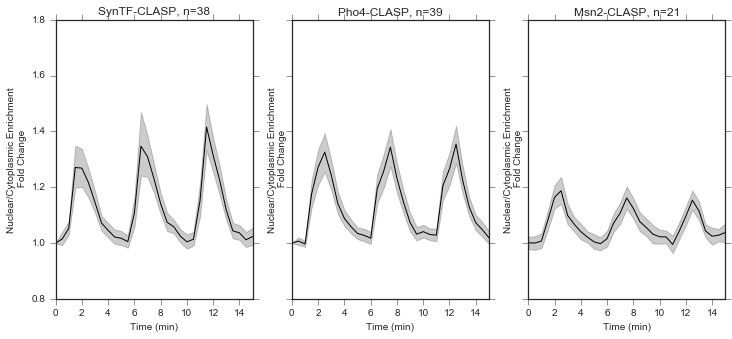

In [23]:
#plot 1m ON/4m OFF mean of cell traces
fig, ax = plt.subplots(1, 3, sharey = True, sharex=True, figsize=(12, 5))
sns.tsplot(data=longd5mnormNucCyto_133_rm_0613, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[0])
sns.tsplot(data=longd5mnormNucCyto_pho4_rm, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[1])
sns.tsplot(data=longd5mnormNucCyto_msn2_rm_0418_ns,time="timepoint", unit="variable", value="value",err_style='ci_band',
           ci=95, color="black", ax = ax[2])
for i in range(3):
    ax[i].set_xlabel("Time (min)")
    ax[i].set_ylabel("Nuclear/Cytoplasmic Enrichment\n Fold Change")
ax[0].set_title('SynTF-CLASP, n=' + str(d5mnormNucCytoEnr_133_rm_all.shape[1]))
ax[1].set_title('Pho4-CLASP, n=' + str(d5mnormNucCytoEnr_pho4_rm2.shape[1]))
ax[2].set_title('Msn2-CLASP, n=' + str(d5mnormNucCytoEnr_msn2_rm_0418_ns.shape[1]))
plt.ylim(0.8, 1.8)
plt.xlim(0,15)
figure = "Figure2A_"
date = "20180315_0418_0613"
dest = figure + date + '_eachTF_5m_pd_DoseResp_95ci'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png',dpi=300)

In [29]:
##read in nuc, cyt, and bkg score files
p1_40m_nuc, p2_40m_nuc = [pd.read_csv(x, header=None) for x in 
                                                  glob.glob(dataRepo + '20180509_p*CTSeed_expt1_40m_pct_nuc.csv')]
p1_40m_nuc_e2, p2_40m_nuc_e2, p3_40m_nuc_e2, p4_40m_nuc_e2 = [pd.read_csv(x, header=None) for x in 
                                                              glob.glob(dataRepo + '20180509_p*CTSeed_expt2_40m_pct_nuc.csv')]

p1_40m_cyt, p2_40m_cyt = [pd.read_csv(x, header=None) for x in 
                                                  glob.glob(dataRepo + '20180509_p*CTSeed_expt1_40m_pct_cyt.csv')]
p1_40m_cyt_e2, p2_40m_cyt_e2, p3_40m_cyt_e2, p4_40m_cyt_e2 = [pd.read_csv(x, header=None) for x in 
                                                              glob.glob(dataRepo + '20180509_p*CTSeed_expt2_40m_pct_cyt.csv')]

p1_40m_bkg, p2_40m_bkg = [pd.read_csv(x, header=None) for x in 
                                                  glob.glob(dataRepo + '20180509_p*CTSeed_expt1_40m_pct_bkg.csv')]
p1_40m_bkg_e2, p2_40m_bkg_e2, p3_40m_bkg_e2, p4_40m_bkg_e2 = [pd.read_csv(x, header=None) for x in
                                                              glob.glob(dataRepo + '20180509_p*CTSeed_expt2_40m_pct_bkg.csv')]

In [30]:
#adjust nuclear and cytoplasmic intensity by subtracting background
p_40m_nuc_list = [p1_40m_nuc, p2_40m_nuc, p1_40m_nuc_e2, p2_40m_nuc_e2, p3_40m_nuc_e2, p4_40m_nuc_e2]
p_40m_cyt_list = [p1_40m_cyt, p2_40m_cyt, p1_40m_cyt_e2, p2_40m_cyt_e2, p3_40m_cyt_e2, p4_40m_cyt_e2]
p_40m_bkg_list = [p1_40m_bkg, p2_40m_bkg, p1_40m_bkg_e2, p2_40m_bkg_e2, p3_40m_bkg_e2, p4_40m_bkg_e2]

p1_40m_nucAdj, p2_40m_nucAdj, p1_40m_nucAdj_e2, p2_40m_nucAdj_e2, p3_40m_nucAdj_e2, p4_40m_nucAdj_e2 = [bkgAdj(p_40m_nuc_list[i], 
                                                                            p_40m_bkg_list[i]) for i in range(len(p_40m_bkg_list))]
p1_40m_cytAdj, p2_40m_cytAdj, p1_40m_cytAdj_e2, p2_40m_cytAdj_e2, p3_40m_cytAdj_e2, p4_40m_cytAdj_e2 = [bkgAdj(p_40m_cyt_list[i], 
                                                                            p_40m_bkg_list[i]) for i in range(len(p_40m_bkg_list))]

In [31]:
#drop cells which have not been tracked for more than 5 frames
p1_40m_nucAdj_rm_UT, p1_40m_cytAdj_rm_UT = rmUntrackedCells(p1_40m_nucAdj, p1_40m_cytAdj, 5)
p2_40m_nucAdj_rm_UT, p2_40m_cytAdj_rm_UT = rmUntrackedCells(p2_40m_nucAdj, p2_40m_cytAdj, 5)

p1_40m_nucAdj_rm_UT_e2, p1_40m_cytAdj_rm_UT_e2 = rmUntrackedCells(p1_40m_nucAdj_e2, p1_40m_cytAdj_e2, 5)
p2_40m_nucAdj_rm_UT_e2, p2_40m_cytAdj_rm_UT_e2 = rmUntrackedCells(p2_40m_nucAdj_e2, p2_40m_cytAdj_e2, 5)
p3_40m_nucAdj_rm_UT_e2, p3_40m_cytAdj_rm_UT_e2 = rmUntrackedCells(p3_40m_nucAdj_e2, p3_40m_cytAdj_e2, 5)
p4_40m_nucAdj_rm_UT_e2, p4_40m_cytAdj_rm_UT_e2 = rmUntrackedCells(p4_40m_nucAdj_e2, p4_40m_cytAdj_e2, 5)

In [32]:
#calculate nuclear enrichment
p1_40m_nucCytoEnr_rm_UT, p1_40m_normNucCytoEnr_rm_UT = nucEnrich(p1_40m_nucAdj_rm_UT, p1_40m_cytAdj_rm_UT)
p2_40m_nucCytoEnr_rm_UT, p2_40m_normNucCytoEnr_rm_UT = nucEnrich(p2_40m_nucAdj_rm_UT, p2_40m_cytAdj_rm_UT)

p1_40m_nucCytoEnr_rm_UT_e2, p1_40m_normNucCytoEnr_rm_UT_e2 = nucEnrich(p1_40m_nucAdj_rm_UT_e2, p1_40m_cytAdj_rm_UT_e2)
p2_40m_nucCytoEnr_rm_UT_e2, p2_40m_normNucCytoEnr_rm_UT_e2 = nucEnrich(p2_40m_nucAdj_rm_UT_e2, p2_40m_cytAdj_rm_UT_e2)
p3_40m_nucCytoEnr_rm_UT_e2, p3_40m_normNucCytoEnr_rm_UT_e2 = nucEnrich(p3_40m_nucAdj_rm_UT_e2, p3_40m_cytAdj_rm_UT_e2)
p4_40m_nucCytoEnr_rm_UT_e2, p4_40m_normNucCytoEnr_rm_UT_e2 = nucEnrich(p4_40m_nucAdj_rm_UT_e2, p4_40m_cytAdj_rm_UT_e2)

In [33]:
#drop the first frame because many cells are not racked in this frame, which skews the normalized nuc/cyt enrichment
#also light does not turn on until 2 frames in, so this is fine
p1_40m_nucCytoEnr_rm_UT_1, p1_40m_normNucCytoEnr_rm_UT_1 = nucEnrich(p1_40m_nucAdj_rm_UT.iloc[1:, :], 
                                                                     p1_40m_cytAdj_rm_UT.iloc[1:, :])
p2_40m_nucCytoEnr_rm_UT_1, p2_40m_normNucCytoEnr_rm_UT_1 = nucEnrich(p2_40m_nucAdj_rm_UT.iloc[1:, :], 
                                                                     p2_40m_cytAdj_rm_UT.iloc[1:, :])

p1_40m_nucCytoEnr_rm_UT_e2_1, p1_40m_normNucCytoEnr_rm_UT_e2_1 = nucEnrich(p1_40m_nucAdj_rm_UT_e2.iloc[1:, :], 
                                                                           p1_40m_cytAdj_rm_UT_e2.iloc[1:, :])
p2_40m_nucCytoEnr_rm_UT_e2_1, p2_40m_normNucCytoEnr_rm_UT_e2_1 = nucEnrich(p2_40m_nucAdj_rm_UT_e2.iloc[1:, :], 
                                                                           p2_40m_cytAdj_rm_UT_e2.iloc[1:, :])
p3_40m_nucCytoEnr_rm_UT_e2_1, p3_40m_normNucCytoEnr_rm_UT_e2_1 = nucEnrich(p3_40m_nucAdj_rm_UT_e2.iloc[1:, :], 
                                                                           p3_40m_cytAdj_rm_UT_e2.iloc[1:, :])
p4_40m_nucCytoEnr_rm_UT_e2_1, p4_40m_normNucCytoEnr_rm_UT_e2_1 = nucEnrich(p4_40m_nucAdj_rm_UT_e2.iloc[1:, :], 
                                                                           p4_40m_cytAdj_rm_UT_e2.iloc[1:, :])

In [36]:
#remove cells which have a negative value at any point
p1_40m_normNucCytoEnr_rm2 = rmOutliers(p1_40m_normNucCytoEnr_rm_UT, 0)
p2_40m_normNucCytoEnr_rm2 = rmOutliers(p2_40m_normNucCytoEnr_rm_UT, 0)

p1_40m_normNucCytoEnr_rm2_e2 = rmOutliers(p1_40m_normNucCytoEnr_rm_UT_e2, 0)
p2_40m_normNucCytoEnr_rm2_e2 = rmOutliers(p2_40m_normNucCytoEnr_rm_UT_e2, 0)
p3_40m_normNucCytoEnr_rm2_e2 = rmOutliers(p3_40m_normNucCytoEnr_rm_UT_e2, 0)
p4_40m_normNucCytoEnr_rm2_e2 = rmOutliers(p4_40m_normNucCytoEnr_rm_UT_e2, 0)

p1_40m_normNucCytoEnr_rm2_1 = rmOutliers(p1_40m_normNucCytoEnr_rm_UT_1, 0)
p2_40m_normNucCytoEnr_rm2_1 = rmOutliers(p2_40m_normNucCytoEnr_rm_UT_1, 0)

p1_40m_normNucCytoEnr_rm2_e2_1 = rmOutliers(p1_40m_normNucCytoEnr_rm_UT_e2_1, 0)
p2_40m_normNucCytoEnr_rm2_e2_1 = rmOutliers(p2_40m_normNucCytoEnr_rm_UT_e2_1, 0)
p3_40m_normNucCytoEnr_rm2_e2_1 = rmOutliers(p3_40m_normNucCytoEnr_rm_UT_e2_1, 0)
p4_40m_normNucCytoEnr_rm2_e2_1 = rmOutliers(p4_40m_normNucCytoEnr_rm_UT_e2_1, 0)

In [37]:
#convert wide dataframe to long; focus on timecourses with first frame dropped
long_p1_40m_normNucCytoEnr_rm2_1 = pd.melt(p1_40m_normNucCytoEnr_rm2_1)
long_p2_40m_normNucCytoEnr_rm2_1 = pd.melt(p2_40m_normNucCytoEnr_rm2_1)

long_p1_40m_normNucCytoEnr_rm2_1["timepoint"] = range(1,p1_40m_normNucCytoEnr_rm2_1.shape[0]+1)*p1_40m_normNucCytoEnr_rm2_1.shape[1]
long_p2_40m_normNucCytoEnr_rm2_1["timepoint"] = range(1,p2_40m_normNucCytoEnr_rm2_1.shape[0]+1)*p2_40m_normNucCytoEnr_rm2_1.shape[1]

long_p1_40m_normNucCytoEnr_rm2_1["TF"] = ["SynTF"]*long_p1_40m_normNucCytoEnr_rm2_1.shape[0]
long_p2_40m_normNucCytoEnr_rm2_1["TF"] = ["SynTF"]*long_p2_40m_normNucCytoEnr_rm2_1.shape[0]

long_p2_40m_normNucCytoEnr_rm2_1["variable"] +=100
long_yLO133_40m_normNucCytoEnr_rm2_1 = pd.concat([long_p1_40m_normNucCytoEnr_rm2_1, long_p2_40m_normNucCytoEnr_rm2_1])


In [38]:
#convert wide dataframe to long; focus on timecourses with first frame dropped
long_p1_40m_normNucCytoEnr_rm2_e2_1 = pd.melt(p1_40m_normNucCytoEnr_rm2_e2_1)
long_p2_40m_normNucCytoEnr_rm2_e2_1 = pd.melt(p2_40m_normNucCytoEnr_rm2_e2_1)
long_p3_40m_normNucCytoEnr_rm2_e2_1 = pd.melt(p3_40m_normNucCytoEnr_rm2_e2_1)
long_p4_40m_normNucCytoEnr_rm2_e2_1 = pd.melt(p4_40m_normNucCytoEnr_rm2_e2_1)

long_p1_40m_normNucCytoEnr_rm2_e2_1["timepoint"] = range(1,p1_40m_normNucCytoEnr_rm2_e2_1.shape[0]+1)*p1_40m_normNucCytoEnr_rm2_e2_1.shape[1]
long_p2_40m_normNucCytoEnr_rm2_e2_1["timepoint"] = range(1,p2_40m_normNucCytoEnr_rm2_e2_1.shape[0]+1)*p2_40m_normNucCytoEnr_rm2_e2_1.shape[1]
long_p3_40m_normNucCytoEnr_rm2_e2_1["timepoint"] = range(1,p3_40m_normNucCytoEnr_rm2_e2_1.shape[0]+1)*p3_40m_normNucCytoEnr_rm2_e2_1.shape[1]
long_p4_40m_normNucCytoEnr_rm2_e2_1["timepoint"] = range(1,p4_40m_normNucCytoEnr_rm2_e2_1.shape[0]+1)*p4_40m_normNucCytoEnr_rm2_e2_1.shape[1]

long_p1_40m_normNucCytoEnr_rm2_e2_1["TF"] = ["Msn2"]*long_p1_40m_normNucCytoEnr_rm2_e2_1.shape[0]
long_p2_40m_normNucCytoEnr_rm2_e2_1["TF"] = ["Msn2"]*long_p2_40m_normNucCytoEnr_rm2_e2_1.shape[0]
long_p3_40m_normNucCytoEnr_rm2_e2_1["TF"] = ["Pho4"]*long_p3_40m_normNucCytoEnr_rm2_e2_1.shape[0]
long_p4_40m_normNucCytoEnr_rm2_e2_1["TF"] = ["Pho4"]*long_p4_40m_normNucCytoEnr_rm2_e2_1.shape[0]

long_p2_40m_normNucCytoEnr_rm2_e2_1["variable"] +=100
long_p4_40m_normNucCytoEnr_rm2_e2_1["variable"] +=100

#p1_40m_e2 seems to have a very strange noise between 15-25 mins after light input. This may be entirely due to processing 
#as the p1 and p2 images look very similar by eye during this time period. As a result, only the traces from p2 will be used
#to represent the constant localization in the main figure
long_yLO228_40m_normNucCytoEnr_rm2_1 = pd.concat([long_p1_40m_normNucCytoEnr_rm2_e2_1, long_p2_40m_normNucCytoEnr_rm2_e2_1])
long_yLO204_40m_normNucCytoEnr_rm2_1 = pd.concat([long_p3_40m_normNucCytoEnr_rm2_e2_1, long_p4_40m_normNucCytoEnr_rm2_e2_1])

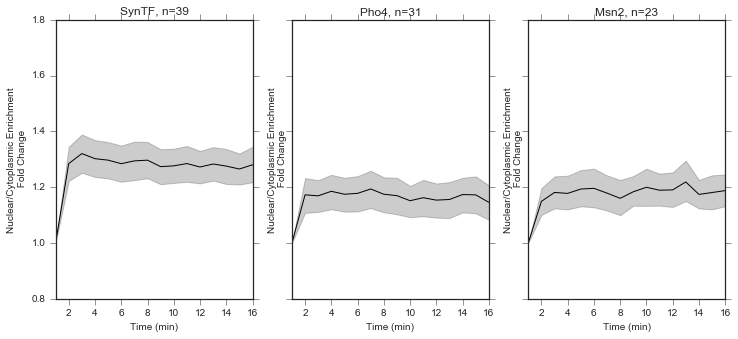

In [39]:
#plot mean cell traces for 40m input
fig, ax = plt.subplots(1, 3, sharey = True, sharex=True, figsize=(12, 5))
sns.tsplot(data=long_yLO133_40m_normNucCytoEnr_rm2_1,time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[0])
sns.tsplot(data=long_yLO204_40m_normNucCytoEnr_rm2_1, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[1])
sns.tsplot(data=long_p2_40m_normNucCytoEnr_rm2_e2_1, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[2])
#plt.suptitle("TF-LANSTrap localization response to blue light, n=" + 
          #str(d5mnormNucCytoEnr_223_rm_all.shape[1]) + ',' + str(d5mnormNucCytoEnr_msn2_rm_0418_ns.shape[1]) + 
          #',' + str(d5mnormNucCytoEnr_pho4_rm.shape[1]) + ',' + str(d5mnormNucCytoEnr_133_rm_all.shape[1]) + 
          #',' + str(d5mnormNucCytoEnr_gal4_rm.shape[1]))
#plt.xlabel("Timepoint")
#plt.ylabel("Normalized Nuclear/Cytolasmic Enrichment")
ax[0].set_title('SynTF, n=' + str(p1_40m_normNucCytoEnr_rm2_1.shape[1] + p2_40m_normNucCytoEnr_rm2_1.shape[1]))
ax[1].set_title('Pho4, n=' + str(p3_40m_normNucCytoEnr_rm2_e2_1.shape[1] + p4_40m_normNucCytoEnr_rm2_e2_1.shape[1]))
ax[2].set_title('Msn2, n=' + str(p2_40m_normNucCytoEnr_rm2_e2_1.shape[1]))
plt.ylim(0.8, 1.8)
plt.xlim(1, 16)
for i in range(3):
    ax[i].set_xlabel("Time (min)")
    ax[i].set_ylabel("Nuclear/Cytoplasmic Enrichment\n Fold Change")
figure = "Figure2A_"
dest = figure + date + '_eachTF_40mResp_95ci'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png',dpi=300)

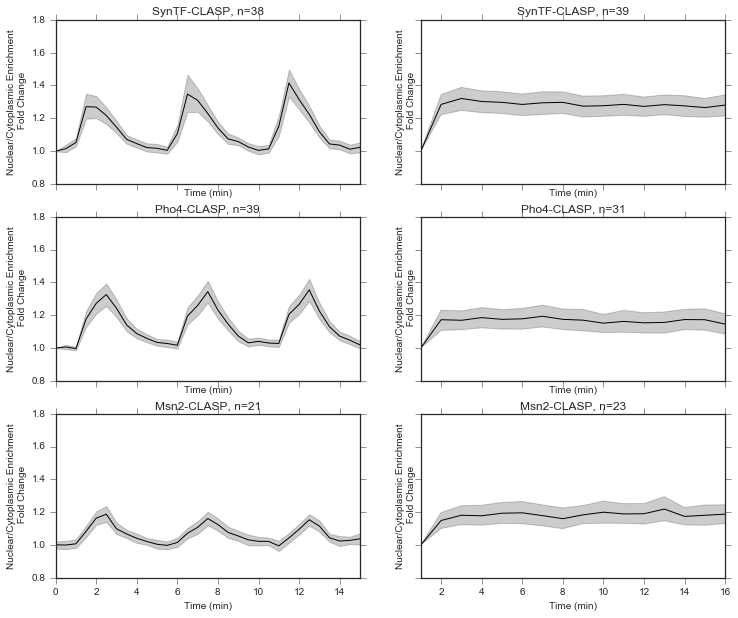

In [41]:
#plot pulsed and constant side by side
fig, ax = plt.subplots(3, 2, sharey = True, sharex="col", figsize=(12, 10))
sns.tsplot(data=longd5mnormNucCyto_133_rm_0613, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[0, 0])
sns.tsplot(data=longd5mnormNucCyto_pho4_rm, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[1, 0])
sns.tsplot(data=longd5mnormNucCyto_msn2_rm_0418_ns,time="timepoint", unit="variable", value="value",err_style='ci_band',
           ci=95, color="black", ax = ax[2, 0])
sns.tsplot(data=long_yLO133_40m_normNucCytoEnr_rm2_1,time="timepoint", unit="variable", value="value",err_style='ci_band',
           ci=95, color="black", ax = ax[0, 1])
sns.tsplot(data=long_yLO204_40m_normNucCytoEnr_rm2_1, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[1, 1])
sns.tsplot(data=long_p2_40m_normNucCytoEnr_rm2_e2_1, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci=95, color="black", ax = ax[2, 1])

ax[0, 0].set_title('SynTF-CLASP, n=' + str(d5mnormNucCytoEnr_133_rm_all.shape[1]))
ax[1, 0].set_title('Pho4-CLASP, n=' + str(d5mnormNucCytoEnr_pho4_rm2.shape[1]))
ax[2, 0].set_title('Msn2-CLASP, n=' + str(d5mnormNucCytoEnr_msn2_rm_0418_ns.shape[1]))

ax[0, 1].set_title('SynTF-CLASP, n=' + str(p1_40m_normNucCytoEnr_rm2_1.shape[1] + p2_40m_normNucCytoEnr_rm2_1.shape[1]))
ax[1, 1].set_title('Pho4-CLASP, n=' + str(p3_40m_normNucCytoEnr_rm2_e2_1.shape[1] + p4_40m_normNucCytoEnr_rm2_e2_1.shape[1]))
ax[2, 1].set_title('Msn2-CLASP, n=' + str(p2_40m_normNucCytoEnr_rm2_e2_1.shape[1]))

plt.ylim(0.8, 1.8)
ax[0,0].set_xlim(0, 15)
ax[0,1].set_xlim(1, 16)
for i in range(3):
    for j in range(2):
        ax[i, j].set_xlabel("Time (min)")
        ax[i, j].set_ylabel("Nuclear/Cytoplasmic Enrichment\n Fold Change")

figure = "Figure2A_"
date = "20180315_0418_0613"
dest = figure + date + '_eachTF_5m_pd_40m_on_95ci'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png',dpi=300)


# Figure 2B 

In [46]:
#load platemaps which detail the location of each strain and dose for syntf and pho4
pTimeMap_133204_1, pCtrlMap_133204_1, pDarkMap_133204_1 = [pd.read_csv(x) for x in 
                                                glob.glob(dataRepo + '20180528_LVTRPLANS_durResp_133204_ctrls/PlateMap*.csv')]
pTimeMap_133204_2, pDark_CtrlMap_133204_2 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo + '20180612_lvtrplans_durResp_133204_ctrls/PlateMap*.csv')]
pTimeMap_133204_3, pDark_CtrlMap_133204_3 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo + '20180614_lvtrplans_durResp_133204_ctrls/PlateMap*.csv')]

In [50]:
#save the names of the directories which hold the actual flow cytometry data
datadir_133204_1_1 = dataRepo + '20180528_LVTRPLANS_durResp_133204_ctrls/P1/'
datadir_133204_1_2 = dataRepo + '20180528_LVTRPLANS_durResp_133204_ctrls/PDark/'
datadir_133204_1_3 = dataRepo + '20180528_LVTRPLANS_durResp_133204_ctrls/PCtrls/'
datadir_133204_2_1 = dataRepo + '20180612_lvtrplans_durResp_133204_ctrls/P1/'
datadir_133204_2_2 = dataRepo + '20180612_lvtrplans_durResp_133204_ctrls/PDark_Ctrls/'
datadir_133204_3_1 = dataRepo + '20180614_lvtrplans_durResp_133204_ctrls/P1/'
datadir_133204_3_2 = dataRepo + '20180614_lvtrplans_durResp_133204_ctrls/PDark_Ctrls/'

datadir_133204 = [datadir_133204_1_1, datadir_133204_1_2, datadir_133204_1_3, datadir_133204_2_1, 
                  datadir_133204_2_2, datadir_133204_3_1, datadir_133204_3_2]

files_133204_1_1,files_133204_1_2,files_133204_1_3,files_133204_2_1,files_133204_2_2,files_133204_3_1,files_133204_3_2 = [glob.glob(x + '*.fcs') 
                                                                                                        for x in datadir_133204]

In [51]:
#load platemaps which detail the location of each strain and dose for msn2
pTimeMap_228yps_1, pDark_CtrlMap_228yps_1 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo + '20180613_lvtrplans_durResp_228yps_ctrls/PlateMap*.csv')]
pTimeMap_228yps_2, pDark_CtrlMap_228yps_2 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo + '20180614_lvtrplans_durResp_228yps_ctrls/PlateMap*.csv')]
pTimeMap_228yps_3, pDark_CtrlMap_228yps_3 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo + '20180621_lvtrplans_durResp_228yps_ctrls/PlateMap*.csv')]

In [52]:
#save the names of the directories which hold the actual flow cytometry data
datadir_228yps_1_1 = dataRepo + '20180613_lvtrplans_durResp_228yps_ctrls/P1/'
datadir_228yps_1_2 = dataRepo + '20180613_lvtrplans_durResp_228yps_ctrls/PDark_Ctrls/'
datadir_228yps_2_1 = dataRepo + '20180614_lvtrplans_durResp_228yps_ctrls/P1/'
datadir_228yps_2_2 = dataRepo + '20180614_lvtrplans_durResp_228yps_ctrls/PDark_Ctrls/'
datadir_228yps_3_1 = dataRepo + '20180621_lvtrplans_durResp_228yps_ctrls/P1/'
datadir_228yps_3_2 = dataRepo + '20180621_lvtrplans_durResp_228yps_ctrls/PDark_Ctrls/'

datadir_228yps = [datadir_228yps_1_1, datadir_228yps_1_2, datadir_228yps_2_1, datadir_228yps_2_2, 
                  datadir_228yps_3_1, datadir_228yps_3_2]
files_228yps_1_1,files_228yps_1_2,files_228yps_2_1,files_228yps_2_2,files_228yps_3_1,files_228yps_3_2 = [glob.glob(x + '*.fcs') 
                                                                                                    for x in datadir_228yps]

In [53]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [55]:
#load flow cytometry data into a plate layout for synTF and pho4
plateraw_P1_133204_1, plateraw_PD_133204_1, plateraw_PC_133204_1 = [pd.DataFrame(index = rows) for i in range(3)]
plateraw_P1_133204_2, plateraw_PD_C_133204_2, plateraw_P1_133204_3, plateraw_PD_C_133204_3 = [pd.DataFrame(index = rows) for i 
                                                                                              in range(4)]
files_133204 = [files_133204_1_1, files_133204_1_2, files_133204_1_3, 
                files_133204_2_1, files_133204_2_2, files_133204_3_1, files_133204_3_2]
plateraw_133204 = [plateraw_P1_133204_1, plateraw_PD_133204_1, plateraw_PC_133204_1, 
                   plateraw_P1_133204_2, plateraw_PD_C_133204_2, plateraw_P1_133204_3, plateraw_PD_C_133204_3]

#parse file names to get plate location
for file_plate_ind in range(len(files_133204)):
    for i in range(len(files_133204[file_plate_ind])):
        c = files_133204[file_plate_ind][i][-6:-4]
        r = files_133204[file_plate_ind][i][-7]
        call = r + c
        plateraw_133204[file_plate_ind].loc[r,c] = FCMeasurement(ID = call, datafile = files_133204[file_plate_ind][i])

#load flow cytometry data into a plate layout for msn2
plateraw_P1_228yps_1, plateraw_PD_C_228yps_1, plateraw_P1_228yps_2 = [pd.DataFrame(index = rows) for i in range(3)]
plateraw_PD_C_228yps_2, plateraw_P1_228yps_3, plateraw_PD_C_228yps_3 = [pd.DataFrame(index = rows) for i in range(3)]
files_228yps = [files_228yps_1_1, files_228yps_1_2, files_228yps_2_1, files_228yps_2_2, files_228yps_3_1, files_228yps_3_2]
plateraw_228yps = [plateraw_P1_228yps_1, plateraw_PD_C_228yps_1, plateraw_P1_228yps_2, 
                   plateraw_PD_C_228yps_2, plateraw_P1_228yps_3, plateraw_PD_C_228yps_3]

#parse file names to get plate location
for file_plate_ind in range(len(files_228yps)):
    for i in range(len(files_228yps[file_plate_ind])):
        c = files_228yps[file_plate_ind][i][-6:-4]
        r = files_228yps[file_plate_ind][i][-7]
        call = r + c
        plateraw_228yps[file_plate_ind].loc[r,c] = FCMeasurement(ID = call, datafile = files_228yps[file_plate_ind][i])

In [56]:
[platesort_P1_133204_1, platesort_PD_133204_1, platesort_PC_133204_1, platesort_P1_133204_2, 
 platesort_PD_C_133204_2, platesort_P1_133204_3, platesort_PD_C_133204_3] = [plateraw.loc[rows,cols] 
                                                                             for plateraw in plateraw_133204]

[platesort_P1_228yps_1, platesort_PD_C_228yps_1, platesort_P1_228yps_2, 
 platesort_PD_C_228yps_2, platesort_P1_228yps_3, platesort_PD_C_228yps_3] = [plateraw.loc[rows,cols] 
                                                                             for plateraw in plateraw_228yps]

In [57]:
def plateMapParse(PMdf, numDose):
    #parse the csv file with strain and dose information; does not handle repeated unique strain names
    #PMdf is a dataframe; numDose is an int declaring how many doses there are in the csv file
    doseList = np.unique(PMdf['Dose'])
    rowDictList, colDictList = [], []
    for doseInd in range(numDose):
        doseRowDict, doseColDict = {}, {}
        for dfRowInd in range(len(PMdf)):
            if PMdf['Dose'][dfRowInd] == doseList[doseInd] and PMdf['Strain'][dfRowInd] > 0:
                ##0 indexes row and column locations
                doseRowDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Row'][dfRowInd]-1
                doseColDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Col'][dfRowInd]-1
        rowDictList.append(doseRowDict.copy())
        colDictList.append(doseColDict.copy())
    return(rowDictList, colDictList)

def plateMapParseReps(PMdf, numDose):
    #parse the csv file with strain and dose information, and return the location of up to two replicates for each unique strain
    #name
    #used to save data from technical replicates
    #PMdf is a dataframe; numDose is an int declaring how many doses there are in the csv file
    doseList = np.unique(PMdf['Dose'])
    rowDictList, colDictList, rowDictListRep, colDictListRep = [], [], [], []
    for doseInd in range(numDose):
        doseRowDict, doseColDict, doseRowDictRep, doseColDictRep = {}, {}, {}, {}
        for dfRowInd in range(len(PMdf)):
            if PMdf['Dose'][dfRowInd] == doseList[doseInd] and PMdf['Strain'][dfRowInd] > 0:
                ##0 indexes row and column locations
                ##if strain num has already been seen, put into replicate dictionary
                if str(PMdf['Strain'][dfRowInd]) in doseRowDict.keys():
                    doseRowDictRep[str(PMdf['Strain'][dfRowInd])] = PMdf['Row'][dfRowInd]-1
                    doseColDictRep[str(PMdf['Strain'][dfRowInd])] = PMdf['Col'][dfRowInd]-1
                else:
                    doseRowDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Row'][dfRowInd]-1
                    doseColDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Col'][dfRowInd]-1
        rowDictList.append(doseRowDict.copy())
        colDictList.append(doseColDict.copy())
        rowDictListRep.append(doseRowDictRep.copy())
        colDictListRep.append(doseColDictRep.copy())
    return(rowDictList, colDictList, rowDictListRep, colDictListRep)

In [58]:
def cleandata(array,thresh):
    #drop data below a threshold (thresh)
    for i in range(len(array)):
        if array[i] <= thresh:
            array[i] = np.nan
    return array

def gate(FCMeasurement,gatedata,minimum, gatedata1, minimum1, gatedata2, minimum2):
    #gate data based on multiple channels
    try:
        FCMgate = (FCMeasurement.data[(FCMeasurement.data[gatedata] > minimum) & 
                                      (FCMeasurement.data[gatedata1] > minimum1) & (FCMeasurement.data[gatedata2] > minimum2)])
        return FCMgate
    except AttributeError:
        return np.nan
def FCdatastats(platesort,normalized,rows,cols,FITCthresh,mCherrythresh,SSCthresh):
    
    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty, 'clean':empty})
    mCherrystats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty, 'clean':empty})

    for row in rows:
        for col in cols:   

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh, 'SSC-H', SSCthresh, 'mCherry-H', mCherrythresh)
                
            except TypeError:
                continue

            try: 
                if normalized == 1:
                    FITC = FCM['FITC-H']/FCM['SSC-H']
                    mCherry = FCM['mCherry-H']/FCM['SSC-H']

                elif normalized == 0:
                    FITC = FCM['FITC-H']
                    mCherry = FCM['mCherry-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.avg.loc[row,col])
                #FITCstats.clean.set_value(row, col, cleandata(FITC, FITCthresh))

                mCherrystats.raw.set_value(row, col, mCherry)
                mCherrystats.med.set_value(row,col,mCherry.median(axis=0))
                mCherrystats.avg.set_value(row,col,mCherry.mean(axis=0))
                mCherrystats.sd.set_value(row,col,mCherry.std(axis=0))
                mCherrystats.cv.set_value(row,col,mCherrystats.avg.loc[row,col]/mCherrystats.avg.loc[row,col])
                #mCherrystats.clean.set_value(row, col, cleandata(mCherry, mCherrythresh))

            except (AttributeError, TypeError):
                continue
    
    return [FITCstats, mCherrystats]

In [59]:
#gate data for flow cytometry experiments on FITC (>=100, or approx bkg fluorescence) and side scatter (>= 2000)
[FITCnorm_P1_133204_1, mCherrynorm_P1_133204_1] = FCdatastats(platesort_P1_133204_1,1,rows,cols,100,0,2000)
[FITC_P1_133204_1, mCherry_P1_133204_1] = FCdatastats(platesort_P1_133204_1,0,rows,cols,100,0,2000)
[FITCnorm_PD_133204_1, mCherrynorm_PD_133204_1] = FCdatastats(platesort_PD_133204_1,1,rows,cols,100,0,2000)
[FITC_PD_133204_1, mCherry_PD_133204_1] = FCdatastats(platesort_PD_133204_1,0,rows,cols,100,0,2000)
[FITCnorm_PC_133204_1, mCherrynorm_PC_133204_1] = FCdatastats(platesort_PC_133204_1,1,rows,cols,100,0,2000)
[FITC_PC_133204_1, mCherry_PC_133204_1] = FCdatastats(platesort_PC_133204_1,0,rows,cols,100,0,2000)

[FITCnorm_P1_133204_2, mCherrynorm_P1_133204_2] = FCdatastats(platesort_P1_133204_2,1,rows,cols,100,0,2000)
[FITC_P1_133204_2, mCherry_P1_133204_2] = FCdatastats(platesort_P1_133204_2,0,rows,cols,100,0,2000)
[FITCnorm_PD_C_133204_2, mCherrynorm_PD_C_133204_2] = FCdatastats(platesort_PD_C_133204_2,1,rows,cols,100,0,2000)
[FITC_PD_C_133204_2, mCherry_PD_C_133204_2] = FCdatastats(platesort_PD_C_133204_2,0,rows,cols,100,0,2000)

[FITCnorm_P1_133204_3, mCherrynorm_P1_133204_3] = FCdatastats(platesort_P1_133204_3,1,rows,cols,100,0,2000)
[FITC_P1_133204_3, mCherry_P1_133204_3] = FCdatastats(platesort_P1_133204_3,0,rows,cols,100,0,2000)
[FITCnorm_PD_C_133204_3, mCherrynorm_PD_C_133204_3] = FCdatastats(platesort_PD_C_133204_3,1,rows,cols,100,0,2000)
[FITC_PD_C_133204_3, mCherry_PD_C_133204_3] = FCdatastats(platesort_PD_C_133204_3,0,rows,cols,100,0,2000)

In [60]:
#gate data for flow cytometry experiments on FITC (>=100, or approx bkg fluorescence) and side scatter (>= 2000)
[FITCnorm_P1_228yps_1, mCherrynorm_P1_228yps_1] = FCdatastats(platesort_P1_228yps_1,1,rows,cols,100,0,2000)
[FITC_P1_228yps_1, mCherry_P1_228yps_1] = FCdatastats(platesort_P1_228yps_1,0,rows,cols,100,0,2000)
[FITCnorm_PD_C_228yps_1, mCherrynorm_PD_C_228yps_1] = FCdatastats(platesort_PD_C_228yps_1,1,rows,cols,100,0,2000)
[FITC_PD_C_228yps_1, mCherry_PD_C_228yps_1] = FCdatastats(platesort_PD_C_228yps_1,0,rows,cols,100,0,2000)

[FITCnorm_P1_228yps_2, mCherrynorm_P1_228yps_2] = FCdatastats(platesort_P1_228yps_2,1,rows,cols,100,0,2000)
[FITC_P1_228yps_2, mCherry_P1_228yps_2] = FCdatastats(platesort_P1_228yps_2,0,rows,cols,100,0,2000)
[FITCnorm_PD_C_228yps_2, mCherrynorm_PD_C_228yps_2] = FCdatastats(platesort_PD_C_228yps_2,1,rows,cols,100,0,2000)
[FITC_PD_C_228yps_2, mCherry_PD_C_228yps_2] = FCdatastats(platesort_PD_C_228yps_2,0,rows,cols,100,0,2000)


[FITCnorm_P1_228yps_3, mCherrynorm_P1_228yps_3] = FCdatastats(platesort_P1_228yps_3,1,rows,cols,100,0,2000)
[FITC_P1_228yps_3, mCherry_P1_228yps_3] = FCdatastats(platesort_P1_228yps_3,0,rows,cols,100,0,2000)
[FITCnorm_PD_C_228yps_3, mCherrynorm_PD_C_228yps_3] = FCdatastats(platesort_PD_C_228yps_3,1,rows,cols,100,0,2000)
[FITC_PD_C_228yps_3, mCherry_PD_C_228yps_3] = FCdatastats(platesort_PD_C_228yps_3,0,rows,cols,100,0,2000)

In [61]:
def concatReplicates(fluorStats, strainName, doseInd, rowList, colList):
    #concatenate data for results attached to the same strain and dose
    allSampleNames = rowList[doseInd].keys()
    repData = []
    for sampleName in allSampleNames:
        if strainName in sampleName:
            repData.append(fluorStats.raw.iloc[rowList[doseInd][sampleName], colList[doseInd][sampleName]])
    return(pd.concat(repData, ignore_index=True))


In [63]:
#parse platemaps and get location of technical replicates
pDMapRowList1_133204_1, pDMapColList1_133204_1, pDMapRowListR1_133204_1, pDMapColListR1_133204_1 = plateMapParseReps(pDarkMap_133204_1, 1)
pCMapRowList1_133204_1, pCMapColList1_133204_1, pCMapRowListR1_133204_1, pCMapColListR1_133204_1 = plateMapParseReps(pCtrlMap_133204_1, 1)
pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1, pTimeMapRowListR1_133204_1, pTimeMapColListR1_133204_1 = plateMapParseReps(pTimeMap_133204_1, 5)
pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2 = plateMapParseReps(pDark_CtrlMap_133204_2, 2)
pTimeMapRowList1_133204_2, pTimeMapColList1_133204_2, pTimeMapRowListR1_133204_2, pTimeMapColListR1_133204_2 = plateMapParseReps(pTimeMap_133204_2, 5)
pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3 = plateMapParseReps(pDark_CtrlMap_133204_3, 2)
pTimeMapRowList1_133204_3, pTimeMapColList1_133204_3, pTimeMapRowListR1_133204_3, pTimeMapColListR1_133204_3 = plateMapParseReps(pTimeMap_133204_3, 5)

pD_CMapRowList1_228yps_1, pD_CMapColList1_228yps_1, pD_CMapRowListR1_228yps_1, pD_CMapColListR1_228yps_1 = plateMapParseReps(pDark_CtrlMap_228yps_1, 2)
pTimeMapRowList1_228yps_1, pTimeMapColList1_228yps_1, pTimeMapRowListR1_228yps_1, pTimeMapColListR1_228yps_1 = plateMapParseReps(pTimeMap_228yps_1, 5)
pD_CMapRowList1_228yps_2, pD_CMapColList1_228yps_2, pD_CMapRowListR1_228yps_2, pD_CMapColListR1_228yps_2 = plateMapParseReps(pDark_CtrlMap_228yps_2, 2)
pTimeMapRowList1_228yps_2, pTimeMapColList1_228yps_2, pTimeMapRowListR1_228yps_2, pTimeMapColListR1_228yps_2 = plateMapParseReps(pTimeMap_228yps_2, 5)
pD_CMapRowList1_228yps_3, pD_CMapColList1_228yps_3, pD_CMapRowListR1_228yps_3, pD_CMapColListR1_228yps_3 = plateMapParseReps(pDark_CtrlMap_228yps_3, 2)
pTimeMapRowList1_228yps_3, pTimeMapColList1_228yps_3, pTimeMapRowListR1_228yps_3, pTimeMapColListR1_228yps_3 = plateMapParseReps(pTimeMap_228yps_3, 5)

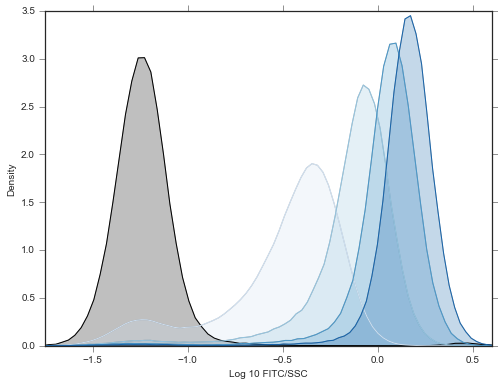

In [64]:
#plot response of SYNTF-CLASP to different durations
seq_col_brew = sns.color_palette("Blues", 4)
sns.set_palette(seq_col_brew)
#yLO133 -- SYNTF-CLASP strain
#yLO171 -- strain with pSYNTF and cytoplasmic SynTF
#pLO411 -- plasmid with SynTF-NLS11, transformed into yAHN437, which yields yLO236
tfList = ['133']
tfCytoKOList = ['171']
tfNLSList = ['411']

fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(8,6))
for rowInd in range(1):
    #plot and concatenate all replicates for the 0 input
    tf0Reps = pd.concat([concatReplicates(FITCnorm_PD_133204_1, tfList[rowInd], 0, pDMapRowList1_133204_1, 
                                          pDMapColList1_133204_1), 
                    concatReplicates(FITCnorm_PD_133204_1, tfList[rowInd], 0, pDMapRowListR1_133204_1, 
                                     pDMapColListR1_133204_1),
                    concatReplicates(FITCnorm_PD_C_133204_2, tfList[rowInd], 0, pD_CMapRowList1_133204_2, 
                                     pD_CMapColList1_133204_2), 
                    concatReplicates(FITCnorm_PD_C_133204_2, tfList[rowInd], 0, pD_CMapRowListR1_133204_2, 
                                     pD_CMapColListR1_133204_2),
                    concatReplicates(FITCnorm_PD_C_133204_3, tfList[rowInd], 0, pD_CMapRowList1_133204_3, 
                                     pD_CMapColList1_133204_3), 
                    concatReplicates(FITCnorm_PD_C_133204_3, tfList[rowInd], 0, pD_CMapRowListR1_133204_3, 
                                     pD_CMapColListR1_133204_3)], 
                    ignore_index=True)
    sns.distplot(np.log10(tf0Reps[~np.isnan(tf0Reps)].astype(float)),color = 'black', ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True})
    #for each light input, of which there are 4, plot and concatenate all replicates
    for tfDoseInd in range(1, 5):
        tfDoseReps = pd.concat([concatReplicates(FITCnorm_P1_133204_1, tfList[rowInd], tfDoseInd, 
                                                 pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1), 
                    concatReplicates(FITCnorm_P1_133204_1, tfList[rowInd], tfDoseInd, pTimeMapRowListR1_133204_1, 
                                     pTimeMapColListR1_133204_1), 
                    concatReplicates(FITCnorm_P1_133204_2, tfList[rowInd], tfDoseInd, pTimeMapRowList1_133204_2, 
                                     pTimeMapColList1_133204_2), 
                    concatReplicates(FITCnorm_P1_133204_2, tfList[rowInd], tfDoseInd, pTimeMapRowListR1_133204_2, 
                                     pTimeMapColListR1_133204_2),
                    concatReplicates(FITCnorm_P1_133204_3, tfList[rowInd], tfDoseInd, pTimeMapRowList1_133204_3, 
                                     pTimeMapColList1_133204_3), 
                    concatReplicates(FITCnorm_P1_133204_3, tfList[rowInd], tfDoseInd, pTimeMapRowListR1_133204_3, 
                                     pTimeMapColListR1_133204_3)], 
                               ignore_index=True)
        sns.distplot(np.log10(tfDoseReps[~np.isnan(tfDoseReps)].astype(float)), ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True})

plt.xlim(-1.75, .6)
plt.ylabel("Density")
plt.xlabel("Log 10 FITC/SSC")
figure = "Figure2B_"
date = '20180528_0612_13_14_21'
dest = figure + date + '_synTF_Pulsing_Comp_kde'
#plt.savefig(os.getcwd() + "/"  + dest + '.svg', bbox_inches='tight',dpi=300)
#plt.savefig(os.getcwd() + "/"  + dest + '.png', bbox_inches='tight',dpi=300)

In [65]:
def longDoseResp(lightStats, lightRowList, lightColList, darkStats, darkRowList, darkColList, strName, numDoses, 
                 doseValList, reps=True):
    #create a long dataframe with response for each dose specified in doseValList
    #dataframe will be the size of the number of cells gathered
    dfList = []
    nonZeroDoseStartingInd = 0
    if doseValList[0] == 0:
        nonZeroDoseStartingInd = 1
        if reps:
            zData = concatReplicates(darkStats, strName, 0, darkRowList, darkColList).to_frame()
        else:
            zData = darkStats.raw.iloc[darkRowList[0][strName], darkColList[0][strName]].to_frame()
        zData['Light Dose'] = [0]*zData.shape[0]
        zData['Strain'] = [strName]*zData.shape[0]
        zData.columns = ['variable', 'Light Dose' , 'Strain']
        dfList.append(zData)
    for doseInd in range(nonZeroDoseStartingInd, numDoses):
        if reps:
            dData = concatReplicates(lightStats, strName, doseInd, lightRowList, lightColList).to_frame()
        else:
            dData = lightStats.raw.iloc[lightRowList[doseInd][strName], lightColList[doseInd][strName]].to_frame()
        dData['Light Dose'] = [doseValList[doseInd]]*dData.shape[0]
        dData['Strain'] = [strName]*dData.shape[0]
        dData.columns = ['variable', 'Light Dose' , 'Strain']
        dfList.append(dData)
    return(pd.concat(dfList, ignore_index=True))

def longDoseRespNorm(lightStats, lightRowList, lightColList, darkStats, darkRowList, darkColList, 
                     strName, numDoses, doseValList, mean_or_median=0, reps=True):
    #create a long dataframe with response for each dose specified in doseValList
    #dataframe will be the size of the number of cells gathered
    #all values will be normalized by the mean or median of the zero dose (mean if mean_or_median == 0)
    dfList = []
    if reps:
        zData = concatReplicates(darkStats, strName, 0, darkRowList, darkColList).to_frame()
    else:
        zData = darkStats.raw.iloc[darkRowList[0][strName], darkColList[0][strName]].to_frame()
    if mean_or_median == 0:
        zDataSummary = zData.mean()
    else:
        zDataSummary = zData.median()
    zDataNorm = zData/zDataSummary
    zDataNorm['Light Dose'] = [0]*zDataNorm.shape[0]
    zDataNorm['Strain'] = [strName]*zDataNorm.shape[0]
    zDataNorm.columns = ['variable', 'Light Dose' , 'Strain']
    dfList.append(zDataNorm)
    for doseInd in range(1, numDoses):
        if reps:
            try:
                #if there is no technical replicate for a light dose, this prevents an error
                dData = concatReplicates(lightStats, strName, doseInd, lightRowList, lightColList).to_frame()
            except ValueError:
                continue
        else:
            dData = lightStats.raw.iloc[lightRowList[doseInd][strName], lightColList[doseInd][strName]].to_frame()
        dDataNorm = dData/zDataSummary
        dDataNorm['Light Dose'] = [doseValList[doseInd]]*dDataNorm.shape[0]
        dDataNorm['Strain'] = [strName]*dDataNorm.shape[0]
        dDataNorm.columns = ['variable', 'Light Dose' , 'Strain']
        dfList.append(dDataNorm)
    return(pd.concat(dfList, ignore_index=True))

def getMeanSDLD(rep1, rep2, strainID, date):
    #calculate the mean and standard deviation for each light dose
    if rep2 is not None:
        allData = pd.concat([rep1, rep2], ignore_index=True)
    else:
        allData = rep1.copy()
    allDataMeans = allData.groupby(["Light Dose", "Strain"]).mean().reset_index()
    allDataMeans['Std Dev'] = allData.groupby(["Light Dose", "Strain"]).std().reset_index()['variable']
    allDataMeans['StrainID'] = [strainID]*allDataMeans.shape[0]
    allDataMeans['Date'] = [date]*allDataMeans.shape[0]
    return allDataMeans

In [66]:
#gather data for Pho4-CLASP and Msn2-CLASP repsonse to duration of light input
strainRespListSEM = []
doseList = [0, 30, 60, 90, 120]
strainReps = ['204.1', '204.2', '204.3']
strainIDs = ['204', '204', '204']
dates = ['0528', '0612', '0614']
for strainRep_ind in range(len(strainReps)):
    strainRespListSEM.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_133204_1, pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1, 
                    FITCnorm_PD_133204_1, pDMapRowList1_133204_1, pDMapColList1_133204_1, strainReps[strainRep_ind], 5, doseList), 
                    longDoseRespNorm(FITCnorm_P1_133204_1, pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1, FITCnorm_PD_133204_1, 
                    pDMapRowList1_133204_1, pDMapColList1_133204_1, strainReps[strainRep_ind], 5, doseList), 
                                         strainIDs[strainRep_ind], dates[0]))
    strainRespListSEM.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_133204_2, pTimeMapRowList1_133204_2, 
                                                          pTimeMapColList1_133204_2, FITCnorm_PD_C_133204_2, 
                    pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2, strainReps[strainRep_ind], 5, doseList), 
                    longDoseRespNorm(FITCnorm_P1_133204_2, pTimeMapRowList1_133204_2, 
                                     pTimeMapColList1_133204_2, FITCnorm_PD_C_133204_2, 
                    pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2, strainReps[strainRep_ind], 5, doseList), 
                                         strainIDs[strainRep_ind], dates[1]))
    strainRespListSEM.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_133204_3, pTimeMapRowList1_133204_3, 
                                                          pTimeMapColList1_133204_3, FITCnorm_PD_C_133204_3, 
                    pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3, strainReps[strainRep_ind], 5, doseList), 
                    longDoseRespNorm(FITCnorm_P1_133204_3, pTimeMapRowList1_133204_3, pTimeMapColList1_133204_3, FITCnorm_PD_C_133204_3, 
                    pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3, strainReps[strainRep_ind], 5, doseList), 
                                         strainIDs[strainRep_ind], dates[2]))
strainReps1 = ['228.1', '228.2', '228.3']
strainIDs1 = ['228', '228', '228']
dates1 = ['0613', '0614', '0621']
for strainRep_ind1 in range(len(strainReps1)):
    strainRespListSEM.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_228yps_1, pTimeMapRowList1_228yps_1, 
                                                          pTimeMapColList1_228yps_1, FITCnorm_PD_C_228yps_1, 
                    pD_CMapRowList1_228yps_1, pD_CMapColList1_228yps_1, strainReps1[strainRep_ind1], 5, doseList), 
                    longDoseRespNorm(FITCnorm_P1_228yps_1, pTimeMapRowList1_228yps_1, pTimeMapColList1_228yps_1, FITCnorm_PD_C_228yps_1, 
                    pD_CMapRowList1_228yps_1, pD_CMapColList1_228yps_1, strainReps1[strainRep_ind1], 5, doseList), 
                                         strainIDs1[strainRep_ind1], dates1[0]))
    strainRespListSEM.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_228yps_2, pTimeMapRowList1_228yps_2, 
                                                          pTimeMapColList1_228yps_2, FITCnorm_PD_C_228yps_2, 
                    pD_CMapRowList1_228yps_2, pD_CMapColList1_228yps_2, strainReps1[strainRep_ind1], 5, doseList), 
                    longDoseRespNorm(FITCnorm_P1_228yps_2, pTimeMapRowList1_228yps_2, pTimeMapColList1_228yps_2, FITCnorm_PD_C_228yps_2, 
                    pD_CMapRowList1_228yps_2, pD_CMapColList1_228yps_2, strainReps1[strainRep_ind1], 5, doseList), 
                                         strainIDs1[strainRep_ind1], dates1[1]))
    strainRespListSEM.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_228yps_3, pTimeMapRowList1_228yps_3, 
                                                          pTimeMapColList1_228yps_3, FITCnorm_PD_C_228yps_3, 
                    pD_CMapRowList1_228yps_3, pD_CMapColList1_228yps_3, strainReps1[strainRep_ind1], 5, doseList), 
                    longDoseRespNorm(FITCnorm_P1_228yps_3, pTimeMapRowList1_228yps_3, pTimeMapColList1_228yps_3, FITCnorm_PD_C_228yps_3, 
                    pD_CMapRowList1_228yps_3, pD_CMapColList1_228yps_3, strainReps1[strainRep_ind1], 5, doseList), 
                                         strainIDs1[strainRep_ind1], dates1[1]))
strainRespDFSEM = pd.concat(strainRespListSEM, ignore_index=True)


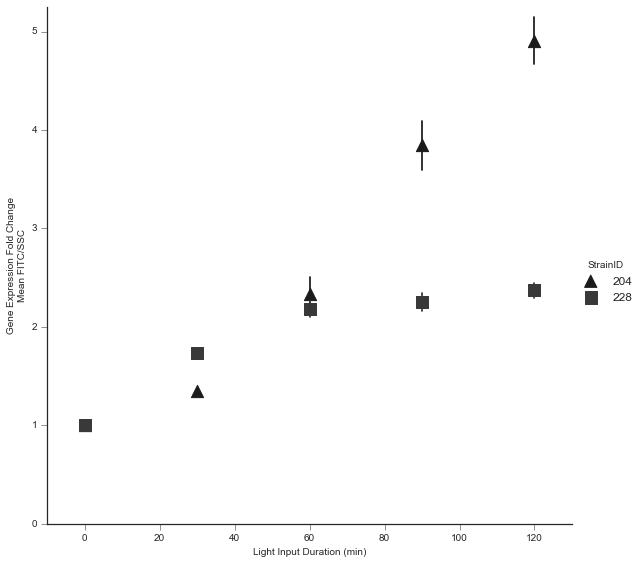

In [67]:
#yLO204 -- Pho4-CLASP
#yLO228 -- Msn2-CLASP
seq_col_brew = sns.color_palette("Greys_r", 10)
sns.set_palette(seq_col_brew)
sns.lmplot('Light Dose', 'variable',
           data=strainRespDFSEM, fit_reg=False, size = 8,
           x_estimator=np.mean, x_ci=68, hue="StrainID", markers = ["^", "s"],
           scatter_kws={"marker": "D",
                        "s": 150})
plt.xlabel('Light Input Duration (min)')
plt.ylabel('Gene Expression Fold Change\nMean FITC/SSC')
plt.ylim(0.0,5.25)
plt.xlim(-10, 130)
figure = "Figure2B_"
date = '20180528_0612_13_14_21'
dest = date + '_204228_Pulsing_Comp_lm_norm_68ci'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/"  + dest + '.png',dpi=300)

# Figure 2C 

In [69]:
#load plate maps, which give information on what strain and dose was used at each plate location
pTimeMap_09, pDarkMap_09 = [pd.read_csv(x) for x in glob.glob(dataRepo + '20180509_LVTRPLANS_Pulsing_ManyTFs/PlateMap*.csv')]
pTimeMap_11, pDarkMap_11 = [pd.read_csv(x) for x in glob.glob(dataRepo + '20180511_LVTRPLANS_Pulsing_ManyTFs/PlateMap*.csv')]
pTimeMap_14, pDarkMap_14 = [pd.read_csv(x) for x in glob.glob(dataRepo + '20180514_LVTRPLANS_Pulsing_ManyTFs/PlateMap*.csv')]

In [70]:
#save names of data directories
datadir1_09 = dataRepo + '/20180509_LVTRPLANS_Pulsing_ManyTFs/P1/'
datadir2_09 = dataRepo + '/20180509_LVTRPLANS_Pulsing_ManyTFs/PDark/'
datadir1_11 = dataRepo + '/20180511_LVTRPLANS_Pulsing_ManyTFs/P1/'
datadir2_11 = dataRepo + '/20180511_LVTRPLANS_Pulsing_ManyTFs/PDark/'
datadir1_14 = dataRepo + '/20180514_LVTRPLANS_Pulsing_ManyTFs/P1/'
datadir2_14 = dataRepo + '/20180514_LVTRPLANS_Pulsing_ManyTFs/PDark/'

datadir_list = [datadir1_09, datadir2_09, datadir1_11, datadir2_11, datadir1_14, datadir2_14]
files1_09, files2_09, files1_11, files2_11, files1_14, files2_14 = [glob.glob(x + '*.fcs') for x in datadir_list]

In [71]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [72]:
#load flow cytometry data into a plate format
plateraw_P1_09, plateraw_PD_09, plateraw_P1_11, plateraw_PD_11, plateraw_P1_14, plateraw_PD_14 = [pd.DataFrame(index = rows) 
                                                                                                  for i in range(6)]
files_list = [files1_09, files2_09, files1_11, files2_11, files1_14, files2_14]
plateraw_list = [plateraw_P1_09, plateraw_PD_09, plateraw_P1_11, plateraw_PD_11, plateraw_P1_14, plateraw_PD_14]
for file_plate_ind in range(len(files_list)):
    for i in range(len(files_list[file_plate_ind])):
        c = files_list[file_plate_ind][i][-6:-4]
        r = files_list[file_plate_ind][i][-7]
        call = r + c
        plateraw_list[file_plate_ind].loc[r,c] = FCMeasurement(ID = call, datafile = files_list[file_plate_ind][i])
        
platesort_P1_09, platesort_PD_09, platesort_P1_11, platesort_PD_11, platesort_P1_14, platesort_PD_14 = [plateraw.loc[rows,cols] 
                                                                                                for plateraw in plateraw_list]

In [73]:
#gate data for flow cytometry experiments on FITC (>=100, or approx bkg fluorescence) and side scatter (>= 2000)
[FITCnorm_P1_09, mCherrynorm_P1_09] = FCdatastats(platesort_P1_09,1,rows,cols,100,0,2000)
[FITC_P1_09, mCherry_P1_09] = FCdatastats(platesort_P1_09,0,rows,cols,100,0,2000)
[FITCnorm_PD_09, mCherrynorm_PD_09] = FCdatastats(platesort_PD_09,1,rows,cols,100,0,2000)
[FITC_PD_09, mCherry_PD_09] = FCdatastats(platesort_PD_09,0,rows,cols,100,0,2000)

[FITCnorm_P1_11, mCherrynorm_P1_11] = FCdatastats(platesort_P1_11,1,rows,cols,100,0,2000)
[FITC_P1_11, mCherry_P1_11] = FCdatastats(platesort_P1_11,0,rows,cols,100,0,2000)
[FITCnorm_PD_11, mCherrynorm_PD_11] = FCdatastats(platesort_PD_11,1,rows,cols,100,0,2000)
[FITC_PD_11, mCherry_PD_11] = FCdatastats(platesort_PD_11,0,rows,cols,100,0,2000)

[FITCnorm_P1_14, mCherrynorm_P1_14] = FCdatastats(platesort_P1_14,1,rows,cols,100,0,2000)
[FITC_P1_14, mCherry_P1_14] = FCdatastats(platesort_P1_14,0,rows,cols,100,0,2000)
[FITCnorm_PD_14, mCherrynorm_PD_14] = FCdatastats(platesort_PD_14,1,rows,cols,100,0,2000)
[FITC_PD_14, mCherry_PD_14] = FCdatastats(platesort_PD_14,0,rows,cols,100,0,2000)


In [74]:
#parse platemap csv's, not taking into account replicates
pDMapRowList_09, pDMapColList_09 = plateMapParse(pDarkMap_09, 1)
pTimeMapRowList_09, pTimeMapColList_09 = plateMapParse(pTimeMap_09, 4)

pDMapRowList_11, pDMapColList_11 = plateMapParse(pDarkMap_11, 1)
pTimeMapRowList_11, pTimeMapColList_11 = plateMapParse(pTimeMap_11, 4)

pDMapRowList_14, pDMapColList_14 = plateMapParse(pDarkMap_14, 1)
pTimeMapRowList_14, pTimeMapColList_14 = plateMapParse(pTimeMap_14, 4)

In [75]:
#parse platemap csv's and get locations for both technical replicates
pDMapRowList1_09, pDMapColList1_09, pDMapRowListR1_09, pDMapColListR1_09 = plateMapParseReps(pDarkMap_09, 1)
pTimeMapRowList1_09, pTimeMapColList1_09, pTimeMapRowListR1_09, pTimeMapColListR1_09 = plateMapParseReps(pTimeMap_09, 4)

pDMapRowList1_11, pDMapColList1_11, pDMapRowListR1_11, pDMapColListR1_11 = plateMapParseReps(pDarkMap_11, 1)
pTimeMapRowList1_11, pTimeMapColList1_11, pTimeMapRowListR1_11, pTimeMapColListR1_11 = plateMapParseReps(pTimeMap_11, 4)

pDMapRowList1_14, pDMapColList1_14, pDMapRowListR1_14, pDMapColListR1_14 = plateMapParseReps(pDarkMap_14, 1)
pTimeMapRowList1_14, pTimeMapColList1_14, pTimeMapRowListR1_14, pTimeMapColListR1_14 = plateMapParseReps(pTimeMap_14, 4)

In [76]:
import scipy.stats
def getMeanSEM(dataDF, strainIDList, lightDoseList, varName="variable"):
    #calculate mean and standard error of the mean for a dataframe
    correspondingStrainList = []
    correspondingDoseList = []
    meanList = []
    semList = []
    for strainID in strainIDList:
        strainDataDF = dataDF.loc[dataDF["Strain"]==strainID, :]
        for doseVal in lightDoseList:
            strainDoseData = strainDataDF.loc[strainDataDF["Light Dose"]==doseVal, varName]
            semList.append(scipy.stats.sem(strainDoseData))
            meanList.append(np.mean(strainDoseData))
            correspondingStrainList.append(strainID)
            correspondingDoseList.append(doseVal)
    meanSEMDF = pd.concat([pd.Series(correspondingStrainList), pd.Series(correspondingDoseList), 
                           pd.Series(meanList), pd.Series(semList)], axis=1)
    meanSEMDF.columns = ["Strain", "Light Dose", "Mean", "SEM"]
    return meanSEMDF

def errplot(x, y, yerr, **kwargs):
    #bar plot using the error values calculated by the above function
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)

In [97]:
#make a long dataframe with the response to pulsed (2) or constant (40) input for SynTF-CLASP (133), 
#Pho4-CLASP (204), or Msn2-CLASP (228)
tfList = ['133', '204','228']
doseList = [0 ,2, 4, 40]
strainRespList1_09 = []
for strainID1_09 in tfList:
    strainRespList1_09.append(longDoseRespNorm(FITCnorm_P1_09, pTimeMapRowList1_09, pTimeMapColList1_09, FITCnorm_PD_09, 
                                               pDMapRowList1_09, pDMapColList1_09, strainID1_09, 4, doseList))
    strainRespList1_09.append(longDoseRespNorm(FITCnorm_P1_09, pTimeMapRowListR1_09, pTimeMapColListR1_09, FITCnorm_PD_09, 
                                               pDMapRowListR1_09, pDMapColListR1_09, strainID1_09, 4, doseList))
strainRespDF1_09 = pd.concat(strainRespList1_09, ignore_index=True)

strainRespList1_11 = []
for strainID1_11 in tfList:
    strainRespList1_11.append(longDoseRespNorm(FITCnorm_P1_11, pTimeMapRowList1_11, pTimeMapColList1_11, FITCnorm_PD_11, 
                                               pDMapRowList1_11, pDMapColList1_11, strainID1_11, 4, doseList))
    strainRespList1_11.append(longDoseRespNorm(FITCnorm_P1_11, pTimeMapRowListR1_11, pTimeMapColListR1_11, FITCnorm_PD_11, 
                                               pDMapRowListR1_11, pDMapColListR1_11, strainID1_11, 4, doseList))
strainRespDF1_11 = pd.concat(strainRespList1_11, ignore_index=True)

strainRespList1_14 = []
for strainID1_14 in tfList:
    strainRespList1_14.append(longDoseRespNorm(FITCnorm_P1_14, pTimeMapRowList1_14, pTimeMapColList1_14, FITCnorm_PD_14, 
                                               pDMapRowList1_14, pDMapColList1_14, strainID1_14, 4, doseList))
    strainRespList1_14.append(longDoseRespNorm(FITCnorm_P1_14, pTimeMapRowListR1_14, pTimeMapColListR1_14, FITCnorm_PD_14, 
                                               pDMapRowListR1_14, pDMapColListR1_14, strainID1_14, 4, doseList))
strainRespDF1_14 = pd.concat(strainRespList1_14, ignore_index=True)

In [98]:
#calculate the mean for each strain/dose combination on each day
meanRespNorm_09 = strainRespDF1_09.groupby(["Light Dose", "Strain"]).mean().reset_index()
meanRespNorm_11 = strainRespDF1_11.groupby(["Light Dose", "Strain"]).mean().reset_index()
meanRespNorm_14 = strainRespDF1_14.groupby(["Light Dose", "Strain"]).mean().reset_index()

meanRespNorm_09["Expt Date"] = ["0509"]*meanRespNorm_09.shape[0]
meanRespNorm_11["Expt Date"] = ["0511"]*meanRespNorm_11.shape[0]
meanRespNorm_14["Expt Date"] = ["0514"]*meanRespNorm_14.shape[0]
meanRespNorm = pd.concat([meanRespNorm_09, meanRespNorm_11, meanRespNorm_14], ignore_index=True)

In [99]:
meanRespNorm_meanSEM = getMeanSEM(meanRespNorm, tfList, doseList)

meanRespNorm_meanSEM_240 = meanRespNorm_meanSEM.loc[meanRespNorm_meanSEM["Light Dose"] != 4, :].copy()

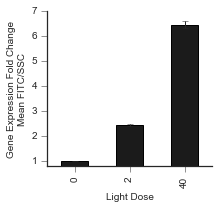

In [100]:
g = sns.FacetGrid(meanRespNorm_meanSEM_240.loc[meanRespNorm_meanSEM_240["Strain"]=="133", :])
g.map_dataframe(errplot, "Light Dose", "Mean", "SEM")
plt.ylabel('Gene Expression Fold Change\nMean FITC/SSC')
plt.ylim(0.8, 7)
dest = date + '_TF_Pulsing_Comp_bar_sem__norm_ylo133_colorblind_non0yaxis'
#plt.savefig(os.getcwd() + "/"  + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/"  + dest + '.png',dpi=300)

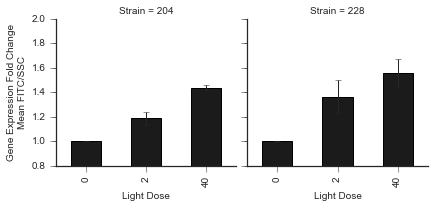

In [101]:
g = sns.FacetGrid(meanRespNorm_meanSEM_240.loc[meanRespNorm_meanSEM_240["Strain"]!="133", :], col="Strain")
g.map_dataframe(errplot, "Light Dose", "Mean", "SEM").set_ylabels('Gene Expression Fold Change\nMean FITC/SSC')
plt.ylim(0.8, 2.0)
dest = date + '_TF_Pulsing_Comp_bar_sem__norm_ylo133_colorblind_non0yaxis'
#plt.savefig(os.getcwd() + "/"  + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/"  + dest + '.png',dpi=300)